#Full script for data analysis from sensor box

49
49
49
49
49
49
49
49
The signals were Gauss filterd.

For this selection, the min and max of temperature are 2.3e+01 and 2.6e+01 respectively.
For this selection, the min and max of light are 3.1e+03 and 3.1e+03 respectively.
For this selection, the min and max of noise-var are 1.1e+02 and 3e+02 respectively.
For this selection, the min and max of noise-max are 2.1e+03 and 2.2e+03 respectively.
For this selection, the min and max of noise-avg are 2.1e+03 and 2.1e+03 respectively.
For this selection, the min and max of pir-percentage are 0.0 and 2.4e+01 respectively.
For this selection, the min and max of num-consecutive-runs are 0.0 and 1.2e+01 respectively.


The signals were normalised.



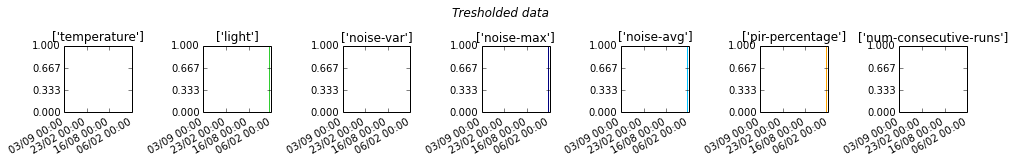

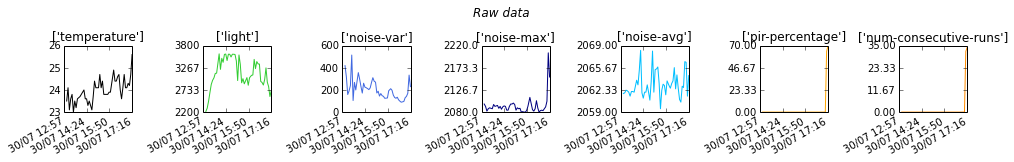

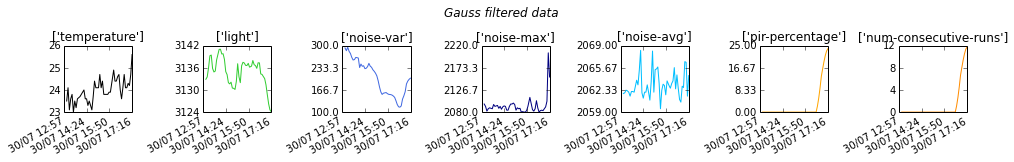

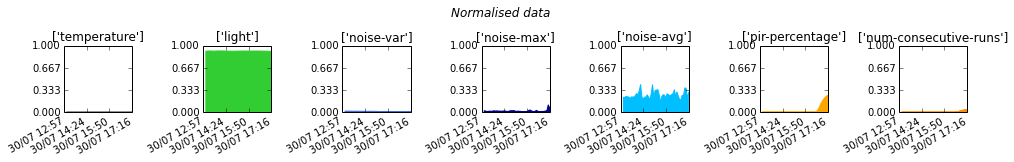

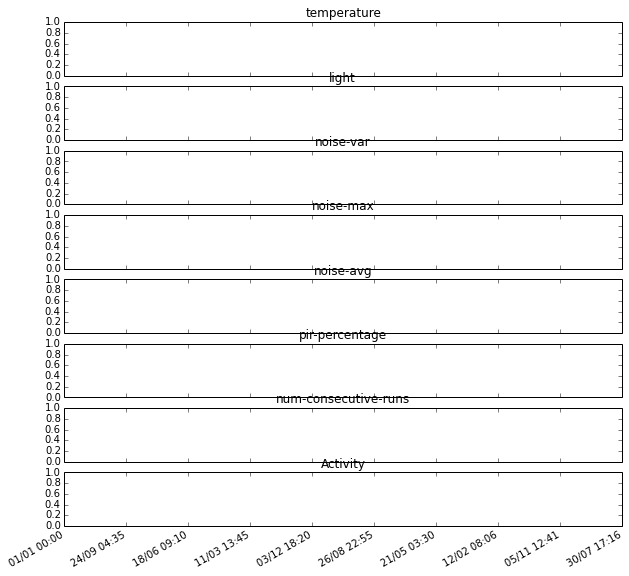

In [116]:
#LOADING PACKAGES
import numpy as np
import pandas as pd

#GUI
import Tkinter as tk

#load data from server and handle json and timestamps
import urllib2
import simplejson as json
from datetime import datetime

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import dates as mdates
from matplotlib.ticker import LinearLocator


###-----FUNCTIONS-----### 
class server_GUI(tk.Frame):
    def __init__(self, parent, date_format, *args, **kwargs):
        tk.Frame.__init__(self, parent, *args, **kwargs)
        self.grid()
        self.parent = parent
        self.date_format = date_format
        
        self.link = ""
        self.devices = ['53ff6d066667574831402467','54ff69066667515129441567']
        self.device = tk.StringVar(self.parent)
        
        self.initial_value = ['Hour','Day','07','2015']
        self.all_options = [['%02d'%(i) for i in range(0,24)],['%02d'%(i) for i in range(1,32)],['%02d'%(i) for i in range(1,13)],range(2015,2016)]
        
    def select_date(self):
        #DEVICE
        self.device.set('53ff6d066667574831402467')
        tk.Label(self.parent, text="Select device:").grid(row=0,column=0)
        apply(tk.OptionMenu, (self.parent, self.device) + tuple(self.devices)).grid(row=0,column=1)
        
        #START DATE
        tk.Label(self.parent, text="Select start date:").grid(row=1)
        self.var_start = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_start[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_start[i]) + tuple(self.all_options[i])).grid(row=2,column=i)
        
        #END DATE
        tk.Label(self.parent, text="Select end date:").grid(row=3)
        self.var_end = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_end[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_end[i]) + tuple(self.all_options[i])).grid(row=4,column=i)
        
        tk.Button(self.parent, text='OK', command=self.ok).grid(row=5,column=5)
        
    def ok(self):
        try:
            start = datetime(int(self.var_start[3].get()),int(self.var_start[2].get()),int(self.var_start[1].get()),int(self.var_start[0].get()))
            end =  datetime(int(self.var_end[3].get()),int(self.var_end[2].get()),int(self.var_end[1].get()),int(self.var_end[0].get()))
            print "The start date is {}, the end date {}, the device number is {}.".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            
            self.link = "http://109.237.25.161/particle/events?start_date={}&end_date={}&device={}".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            print "Created link: {}\n".format(self.link)
            
            self.parent.quit()
            
        except:
            print "Please try again!"

def load_data(device,parameters):
    dat = [[] for par in range(len(parameters))]
    timestamp = []
    
    link_base = "http://109.237.25.161/particle/measurements?device={}&measurement={}"
    
    for par in range(len(parameters)):
        link = link_base.format(device,parameters[par])
        decoded_json = json.loads(urllib2.urlopen(link).read())['events']
                
        for line in decoded_json:
            #print par,":",line["value"],":",pd.Timestamp(line["timestamp"])
            dat[par].append(float(line["value"]))
        
        print len(dat[par])
    
    for line in decoded_json:
        timestamp.append(pd.Timestamp(line["timestamp"]))
    print len(timestamp)
        
    return pd.DataFrame(data=np.array(dat).T,index=timestamp,columns=parameters)

def make_df(data,timestamp,col_names):
    df = pd.DataFrame(data, index=timestamp, columns=col_names)
    df = df.convert_objects(convert_numeric=True)
    
    return df

def plot_data(df,hfmt,cols,title,plt_type):
    var = df.columns.values
    
    fig, axs = plt.subplots(1,len(var), sharex=True, figsize=(2*len(var),2))
    fig.suptitle(title,y=1.1,fontsize=12,style='oblique')

    for i in range(len(var)):
        if plt_type=='line':
            axs[i].plot(df.index,df[var[i]].values,color=cols[var[i]])
        elif plt_type=='fill':
            axs[i].fill_between(df.index,0,df[var[i]].values,color=cols[var[i]])
            axs[i].set_ylim(0,1)
        else:
            print "plt_type invalid!"
            break
        axs[i].set_title([var[i]],fontsize=12)
        axs[i].xaxis.set_major_formatter(hfmt)
        axs[i].xaxis.set_major_locator(LinearLocator(numticks=4))
        axs[i].yaxis.set_major_locator(LinearLocator(numticks=4))
    
    fig.autofmt_xdate()
    fig.tight_layout()
    #fig.show()
    #fig.savefig(title,orientation="landscape")
        
def Gauss_filt(y, M, std):
    from scipy.signal import gaussian
    from scipy.ndimage import filters

    b = gaussian(M, std)
    ga = filters.convolve1d(y, b/b.sum())
    
    return ga

def filt_data(df,var,filt_params):
    filt_sig = np.zeros((len(df.index),len(var)))*np.nan
    
    for i in range(len(var)):
        ##find slices of df which are not NaN
        mask = np.ma.clump_unmasked(np.ma.masked_invalid(df[var[i]].values))
        ##Gauss filter these slices
        for s in range(len(mask)):
            filt_sig[mask[s],i] = Gauss_filt(df[var[i]].values[mask[s]],filt_params[var[i]][0],filt_params[var[i]][1])
    
    print "The signals were Gauss filterd.\n"
    return make_df(filt_sig,df.index,var)

def norm_data(df,min_max,cols):
    var = df.columns.values
    norm_sig = np.zeros(df.shape,dtype=float)*np.nan
    
    for i in range(len(var)):
        norm_sig[:,i] = (df[var[i]]-min_max[var[i]][0])/(min_max[var[i]][1]-min_max[var[i]][0])
        print "For this selection, the min and max of {0} are {1:.2} and {2:.2} respectively.".format(var[i], np.nanmin(df[var[i]].values), np.nanmax(df[var[i]].values))

    print "\n"
    print "The signals were normalised.\n"
    
    return make_df(norm_sig,df.index,var)

def treshold_data(df,treshold):
    lines = np.zeros(df.shape, dtype=int)*np.nan
    var = df.columns.values
        
    for i in range(len(var)):
        lines[:,i] = [1 if x>treshold[var[i]] else np.nan for x in df[var[i]]]
    
    return make_df(lines,df.index,var)
    
def infere(df):
    ###This is still not generalised enough for all parameters we record!!!
    
    day_high = [1 if (x==1 and y==1 and z==1) else np.nan for (x,y,z) in df.values]
    day_low = [1 if (x==1 and y==1 and np.isnan(z)) else np.nan for (x,y,z) in df.values]
    night_high = [1 if (np.isnan(x) and np.isnan(y) and z==1) else np.nan for (x,y,z) in df.values]
    night_low = [1 if (np.isnan(x) and y==1 and np.isnan(z)) else np.nan for (x,y,z) in df.values]
    
    activity = np.array([day_high,day_low,night_high,night_low])
    levels = ["day_high","day_low","night_high","night_low"]
  
    return make_df(activity.T,df.index,levels)

def infere2(df,sunrise,sunset):
    levels = ["day_high","day_low","night_high","night_low"]
    activity = pd.DataFrame(np.zeros((len(df.index),4))*np.nan,index=df.index,columns=levels)
    
    for i in range(24):
        if sunrise <= i < sunset:
            for j, row in df[df.index.hour==i].iterrows():
                if np.nansum(row.values) >= 3:
                    activity["day_high"][activity.index==j] = 1
                elif np.nansum(row.values) == 2:
                    activity["day_low"][activity.index==j] = 1
                else:
                    continue
        else:
            for j, row in df[df.index.hour==i].iterrows():
                if np.nansum(row.values) > 1:
                    activity["night_high"][activity.index==j] = 1
                elif np.nansum(row.values) == 1:
                    activity["night_low"][activity.index==j] = 1
                else:
                    continue
            
    return activity

def line_plot(df,df_act,hfmt,cols):
    var = df.columns.values
    levels = df_act.columns.values
    
    if "day_night" in var:
        n_plots = len(var)
    else:
        n_plots = len(var)+1
    
    fig, axs = plt.subplots(n_plots, 1, sharex=True, sharey=True, figsize=(10,10))

    for i in range(n_plots-1):
        if var[i] != "day_night":
            axs[i].fill_between(df.index,0,df[var[i]].values,color=cols[var[i]])
            axs[i].set_title("{}".format(var[i]))
        else:
            continue
    
    lev_cols = ["orange","wheat","deepskyblue","midnightblue"]
    
    try:
        #plot night-time:
        axs[n_plots-1].fill_between(df.index,0,df["day_night"].values,color="lightgray",alpha=.8)
    except KeyError:
        pass
   
    for j in range(len(levels)):
        axs[n_plots-1].fill_between(df_act.index,0,df_act[levels[j]].values,color=lev_cols[j])
        axs[n_plots-1].set_title("Activity")

    axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
    axs[0].xaxis.set_major_formatter(hfmt)
    axs[0].set_ylim(0,1)
    
    fig.autofmt_xdate()
    
def random_data(n,duration,name):
    from datetime import timedelta
    
    on_off = np.array(n*[1,0], dtype=int)
    time_on = timedelta(minutes=duration)
    rd_date=[]
    
    #random date input
    ye = np.array([2015] * n)
    mo = np.array([7] * n)
    da = np.random.randint(1,6,n)
    ho = np.random.randint(0,24,n)
    mi = np.random.randint(0,60,n)
    
    for i in range(n):
        rd_date.append(datetime(ye[i],mo[i],da[i],ho[i],mi[i]))
        rd_date.append(datetime(ye[i],mo[i],da[i],ho[i],mi[i])+time_on)
    
    return make_df(on_off,np.sort(rd_date),name)

def map_power_data(df,power_data):
    var = power_data.columns.values[0]
    out = np.zeros(len(df.index))*np.nan
    j = 0

    for i in range(len(df.index)):
        if df.index[i] < power_data.index[j] and power_data[var].values[j] == 1:
            continue
        elif df.index[i] < power_data.index[j] and power_data[var].values[j] == 0:
            out[i] = 1
        else:
            if j < len(power_data.index)-1:
                out[i] = power_data[var].values[j]
                j += 1
            else:
                out[i] = np.nan
                
    df_added = df.copy()
    df_added[var] = out
    
    return df_added

def add_day_night(df,sunrise,sunset):
    df["day_night"]=np.nan
    
    for i in range(24):
        if i >= sunset or i <= sunrise:
            df["day_night"][df.index.hour==i] = 1
        else:
            continue

def main():
    ###-----SETUP-----### 
    #format of input
    date_format = '%Y-%m-%d %H:%M:%S' #format of timestamp
    parameters = ["temperature","light","noise-var","noise-max","noise-avg","pir-percentage","num-consecutive-runs"]
    sunrise = 4 
    sunset = 22
    
    #parameters to be analysed
    para = [parameters[1],parameters[2],parameters[4]] #parameters used for analysis
    
    #input for gaussian filter ["number of points in output window","sigma"]
    filt_params = {
        "temperature":[1,1],
        "light":[100,60],
        "noise-max":[1,1],
        "noise-avg":[1,1],
        "noise-var":[10,15],
        "pir-percentage":[15,5],
        "num-consecutive-runs":[15,5]
    }
    
    #minimum and maximum for each paramater between 29/06 and 05/07 (EIETL data); used to normalise data
    min_max = {
            "temperature":[27.7,32.6],
            "light":[341.,3380.],
            "noise-max":[2072.,3298.],
            "noise-avg":[2054.5,2087.8],
            "noise-var":[1.7,20404.3],
            "pir-percentage":[0.,95.],
            "num-consecutive-runs":[0.,301.]
    }

    #tresholds above which paramter is switched to 1 and below which it is set to NaN (empirical)
    tresholds = {
            "temperature":[.2],
            "light":[.1],
            "noise-max":[.05],
            "noise-avg":[.05],
            "noise-var":[.05],
            "pir-percentage":[.05],
            "num-consecutive-runs":[.05]
    }
    
    #plot setup
    hfmt = mdates.DateFormatter('%d/%m %H:%M') #display format of date
    cols = {
        "temperature":"black",
        "light":"limegreen",
        "noise-max":"navy",
        "noise-avg":"deepskyblue",
        "noise-var":"royalblue",
        "pir-percentage":"orange",
        "num-consecutive-runs":"darkorange",
        "power_mon":"violet",
        "day_night":"black"
    }
    
    ###-----ANALYSIS-----### 
    
    #CALL GUI TO SELECT DATE
    #root = tk.Tk()
    #root.title('Select data to be fetched')

    #App = server_GUI(root,date_format)
    #App.select_date()

    #root.mainloop()
    #root.destroy()
    
    #LOAD DATA
    device = ["53ff6d066667574831402467","54ff69066667515129441567"]
    df = load_data(device[1],parameters)
    #device = App.device.get()
    
    #LOOK AT TIME INTERVALLS
    #df = df.resample('5min', how='mean')
    
    #FILTER THE DATA (ONLY OF THE SUBSET "PARA" OF PARAMETERS)
    df_filt = filt_data(df,parameters,filt_params)
    
    #NORMALISE THE DATA 
    #normalise filtered data:
    df_norm = norm_data(df_filt,min_max,cols)
    
    #or normalise raw data(subset):
    #df_norm = norm_data(df[para],min_max,cols)
    
    #TRESHOLD THE NORMALISED DATA
    df_tresh = treshold_data(df_norm,tresholds)
    plot_data(df_tresh,hfmt,cols,"Tresholded data","fill")

    
    #MAKE RANDOM POWER MONITOR DATA
    #power = random_data(n=30,duration=1,name=['power_mon'])
    
    #MAP POWER DATA TO TRESHOLDED DATA
    #df_all = map_power_data(df_tresh,power)
    
    #INFERENCE AND LINEPLOT
    df_activity = infere2(df_tresh,sunrise,sunset)
    
    #ADD DAY AND NIGHT
    add_day_night(df_tresh,sunrise,sunset)
    
    #MAKE PLOTS
    plot_data(df,hfmt,cols,"Raw data","line")
    plot_data(df_filt,hfmt,cols,"Gauss filtered data","line")
    plot_data(df_norm,hfmt,cols,"Normalised data","fill")
    
    line_plot(df_tresh,df_activity,hfmt,cols)

# call main
if __name__ == '__main__':
    main()

In [86]:
dat = [['a']]*5
dat[0].append('b')

print dat

[['a', 'b'], ['a', 'b'], ['a', 'b'], ['a', 'b'], ['a', 'b']]


In [92]:
dat = [[] for par in range(len(parameters))]
dat[0].append(9)
print dat

[[9], [], [], [], [], []]
